# Credit Scoring Business Application

## Overview 

## Objective

This notebook provides an example of **how to train Tensorflow classifiers using the HMEQ dataset**

The goal is to **predict whether a customer is a BAD (default) borrower**, which in this dataset is a binary classification task.

## Assumption

**We are working in big data context**. 

Then, I'm going to work with HMEQ dataset as it is so large that it would not fit in RAM. 

Then **we use the Tensorflow framework to deal with that**.

# 0. Imports and setup

## Libraries

In [3]:
#General
import os
import functools
import shutil
import datetime

#Analysis
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, DenseFeatures, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

#Experiment tracking
import mlflow
mlflow.set_tracking_uri('http://hpecp14.local:10032')
mlflow.set_experiment('Credit Churn')

# Settings
matplotlib.rcParams['figure.figsize'] = (12, 10)
import warnings
warnings.filterwarnings('ignore')

INFO: 'Credit Churn' does not exist. Creating a new experiment


## Setup variables

In [48]:
BASE_DIR_PATH = '/bd-fs-mnt/TenantShare/HMEQ'
DATA_DIR_PATH = '/bd-fs-mnt/TenantShare/HMEQ'

# Data directories paths
TRAIN_DIR_PATH = os.path.join(DATA_DIR_PATH, 'train')
TEST_DIR_PATH = os.path.join(DATA_DIR_PATH, 'test')

# Data file paths
TRAIN_DATA_PATH = os.path.join(TRAIN_DIR_PATH, 'train.csv')
TEST_DATA_PATH = os.path.join(TEST_DIR_PATH, 'test.csv')

# Model directories
LOGS_DIR = os.path.join(BASE_DIR_PATH, 'logs')
MODELS_DIR = os.path.join(BASE_DIR_PATH, 'models')

In [53]:
DATA_DIR_PATH

'/bd-fs-mnt/TenantShare/HMEQ'

## Define Helpers

**Notice**: TF adds tf.keras.layers.experimental.preprocessing to deal with preprocessing tasks

TF needs several preprocessing functions in order to perform data manipulation and feature engineering tasks

In [5]:
## Preprocessing data

def _set_categorical_type(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Set the categorical type as string if neeeded
    :param dataframe: 
    :return: dataframe
    '''
    for column in CATEGORICAL_VARIABLES:
        if (dataframe[column].dtype == 'O'):
            dataframe[column] = dataframe[column].astype('string')
    return dataframe

def _set_categorical_empty(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Change object type for categorical variable to avoid TF issue
    :param dataframe: 
    :return: dataframe
    '''
    for column in CATEGORICAL_VARIABLES:
        if any(dataframe[column].isna()):
            dataframe[column] = dataframe[column].fillna('')
    return dataframe

def _set_numerical_type(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Set the numerical type as float64 if needed
    :param dataframe:
    :return: dataframe
    '''
    for column in NUMERICAL_VARIABLES:
        if (dataframe[column].dtype == 'int64'):
            dataframe[column] = dataframe[column].astype('float64')
    return dataframe

def _get_impute_parameters_cat(categorical_variables: list) -> dict:
    '''
    For each column in the categorical features, assign default value for missings.
    :param categorical_variables:
    :return: impute_parameters
    '''

    impute_parameters = {}
    for column in categorical_variables:
        impute_parameters[column] = 'Missing'
    return impute_parameters
    
def _impute_missing_categorical(inputs: dict, target) -> dict:
    '''
    Given a tf.data.Dataset, impute missing in categorical variables with default 'missing' value
    :param inputs:
    :param target:
    :return: output, target
    '''
    impute_parameters = _get_impute_parameters_cat(CATEGORICAL_VARIABLES)
    # Since we modify just some features, we need to start by setting `outputs` to a copy of `inputs.
    output = inputs.copy()
    for key, value in impute_parameters.items():
        is_blank = tf.math.equal('', inputs[key])
        tf_other = tf.constant(value, dtype=np.string_)
        output[key] = tf.where(is_blank, tf_other, inputs[key])
    return output, target

def _get_mean_parameter(dataframe: pd.DataFrame, column: str) -> float:
    '''
    Given a DataFrame column, calculate mean
    :param dataframe: 
    :param column: 
    :return: mean
    '''
    mean = dataframe[column].mean()
    return mean

def _get_impute_parameters_num(dataframe: pd.DataFrame, numerical_variables: list) -> dict:
    '''
    Given a DataFrame and its numerical variables, return the associated dictionary of means
    :param dataframe: 
    :param numerical_variables: 
    :return: impute_parameters
    '''

    impute_parameters = {}
    for column in numerical_variables:
        impute_parameters[column] = _get_mean_parameter(dataframe, column)
    return impute_parameters

def _impute_missing_numerical(inputs: dict, target) -> dict:
    '''
    Given a tf.data.Dataset, impute missing in numerical variables with training means
    :param inputs:
    :param target:
    :return: output, target
    '''
    # Get mean parameters for imputing 
    impute_parameters = _get_impute_parameters_num(data_train, NUMERICAL_VARIABLES) 
    # Since we modify just some features, we need to start by setting `outputs` to a copy of `inputs.
    output = inputs.copy()
    for key, value in impute_parameters.items():
        # Check if nan (true, false mask)
        is_miss = tf.math.is_nan(inputs[key])
        # Store mean in a tf.constant
        tf_mean = tf.constant(value, dtype=np.float64)
        # Impute missing
        output[key] = tf.where(is_miss, tf_mean, inputs[key])
    return output, target

def _get_std_parameter(dataframe:pd.DataFrame, column:str) -> float:
    '''
    Given a DataFrame column, calculate std
    :param dataframe:
    :param column:
    :return: std
    '''
    std = dataframe[column].std()
    return std

def _get_normalization_parameters(numerical_variables: list) -> dict:
    '''
    For each numerical variable, calculate mean and std based on training dataframe
    :param numerical_variables: 
    :return: normalize_parameters
    '''
    normalize_parameters = {}
    for column in numerical_variables:
        normalize_parameters[column] = {}
        normalize_parameters[column]['mean'] = _get_mean_parameter(data_train, column)
        normalize_parameters[column]['std'] = _get_std_parameter(data_train, column)
    return normalize_parameters
    
def normalizer(column, mean, std):
    '''
    Given a column, Normalize with calculated mean and std
    :param column: 
    :param mean: 
    :param std: 
    :return: 
    '''
    return (column - mean) / std
            
def check_feature(feature_column):
    '''
    Given a tf.feature_column and an iter, transform a batch of data
    :param feature_column:
    :return: None
    '''
    feature_layer = keras.layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch).numpy())
    
def mlflow_experiment_tracker(algo_name):
    """ 
    return the run id and experiment id of model
    args: 
      algo_name: the name of algorithm 
    returns: 
      model, metrics, run_id, experiment_id
    """
    with mlflow.start_run(run_name=algo_name) as run:
        
        # Store run_id and experiment_id
        run_id=run.info.run_uuid
        experiment_id=run.info.experiment_id
        
        #train the model
        model, metrics = train_and_evaluate()
        
        #Log params
        for metric, value in metrics.items():
            mlflow.log_metric(metric, value)
            
    return model, metrics, run_id, experiment_id
    
def calculate_roc(labels, predictions):
    '''
    Given labels and predictions columns,
    calculare ROC
    :param labels:
    :param predictions:
    :return: fpr, tpr
    '''
    fpr, tpr, _ = roc_curve(labels, predictions)
    return fpr, tpr

def calculate_correlation_matrix(labels, predictions, p=0.5):
    '''
    Given labels and predictions columns,
    calculate confusion matrix for a given p
    :param labels: 
    :param predictions: 
    :param p: 
    :return: corrmat
    '''
    corrmat = confusion_matrix(labels, predictions > p)
    return corrmat

def plot_metrics(name, labels, predictions, p=0.5):
    '''
    Plot roc and correlation matrix
    :param name: 
    :param labels: 
    :param predictions: 
    :param p: 
    :return: None
    '''
    metrics = ['roc', 'corrmat']
    for n, metric in enumerate(metrics):
        plt.subplot(2,2,n+1)
        if metric == 'corrmat':
            corrmat = calculate_correlation_matrix(labels, predictions, p)
            sns.heatmap(corrmat, annot=True, fmt="d")
            plt.title(name + ' - ' + 'Confusion matrix with p = {:.2f}'.format(p))
            plt.ylabel('Actual label')
            plt.xlabel('Predicted label')
        if metric == 'roc':
            fpr, tpr = calculate_roc(labels=labels, predictions=predictions)
            plt.plot(fpr, tpr)
            plt.title(name + ' - ' + 'ROC curve')
            plt.xlabel('false positive rate')
            plt.ylabel('true positive rate')
            plt.xlim(0,)
            plt.ylim(0,)

def print_metrics(corrmat, metrics):
    '''
    Show evaluation matrix
    :param corrmat: 
    :param metrics: 
    :return: None
    '''
    print('Correlation matrix info')
    print('True Negatives - No default loans that pay', corrmat[0][0])
    print('False Positives - No default loans that dont pay', corrmat[0][1])
    print('False Negatives - Default loans that pay', corrmat[1][0])
    print('True Positives: - Default loans that dont pay', corrmat[1][1])
    print('Total Defauts: ', np.sum(corrmat[1]))
    print()
    print('-'*20)
    print()
    print('Evalutation Metrics')
    for key, value in metrics.items():
        print(key, ':', value)
        
def setup(folder, modelname):
    '''
    Given root and model name folder,
    remove old version and create a new directory
    :param folder: 
    :param modelname: 
    :return: model_folder
    '''
    model_folder = os.path.join(folder, modelname)
    #if yes, delete it
    if os.path.exists(model_folder):
        shutil.rmtree(model_folder)
        print("Older ", model_folder," folder removed!")
    os.makedirs(model_folder)
    print("Directory ", model_folder," created!")
    return model_folder
    
def copytree(src, dst, symlinks=False, ignore=None):
    '''
    Given src and dst, 
    it copies a directory or a files
    :param src: 
    :param dst: 
    :param symlinks: 
    :param ignore: 
    :return: None
    '''
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

---

# 1. Data

## Preview data

In [6]:
!head -n 5 /bd-fs-mnt/TenantShare/HMEQ/train/train.csv

BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,8400,85136.0,125912.0,HomeImp,Other,9.0,,,,,,40.715178041
0,27700,77886.0,114494.0,DebtCon,ProfExe,9.0,0.0,0.0,118.47135379,0.0,18.0,28.344078391
0,22900,28217.0,52804.0,DebtCon,Other,14.0,0.0,0.0,109.36568457,1.0,25.0,30.587728164
0,13600,41000.0,73440.0,DebtCon,Mgr,4.0,0.0,0.0,125.76666667,1.0,9.0,


## Load Data

In [7]:
data_train = pd.read_csv(TRAIN_DATA_PATH, sep=',')
data_test = pd.read_csv(TEST_DATA_PATH, sep=',')                             

In [8]:
data_train.head(5)                  

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,8400,85136.0,125912.0,HomeImp,Other,9.0,NaN,NaN,NaN,NaN,NaN,40.715178
1,0,27700,77886.0,114494.0,DebtCon,ProfExe,9.0,0.0,0.0,118.471354,0.0,18.0,28.344078
2,0,22900,28217.0,52804.0,DebtCon,Other,14.0,0.0,0.0,109.365685,1.0,25.0,30.587728
3,0,13600,41000.0,73440.0,DebtCon,Mgr,4.0,0.0,0.0,125.766667,1.0,9.0,NaN
4,0,25000,NaN,60685.0,DebtCon,Other,NaN,0.0,0.0,311.935889,0.0,19.0,39.421714


In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5364 entries, 0 to 5363
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5364 non-null   int64  
 1   LOAN     5364 non-null   int64  
 2   MORTDUE  4895 non-null   float64
 3   VALUE    5261 non-null   float64
 4   REASON   5132 non-null   object 
 5   JOB      5113 non-null   object 
 6   YOJ      4904 non-null   float64
 7   DEROG    4737 non-null   float64
 8   DELINQ   4850 non-null   float64
 9   CLAGE    5086 non-null   float64
 10  NINQ     4910 non-null   float64
 11  CLNO     5166 non-null   float64
 12  DEBTINC  4225 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 544.9+ KB


In [10]:
data_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BAD,5364.0,0.201156,0.400902,0.000000,0.000000,0.000000,0.000000,1.000000
LOAN,5364.0,18579.418345,11169.595159,1100.000000,11075.000000,16300.000000,23300.000000,89900.000000
MORTDUE,4895.0,73699.085638,43814.288057,2063.000000,46676.500000,65165.000000,91446.500000,399550.000000
VALUE,5261.0,101477.076324,56093.044109,8000.000000,66217.000000,89145.000000,119846.000000,855909.000000
YOJ,4904.0,8.887898,7.556251,0.000000,3.000000,7.000000,13.000000,41.000000
DEROG,4737.0,0.253325,0.838779,0.000000,0.000000,0.000000,0.000000,10.000000
DELINQ,4850.0,0.454433,1.141145,0.000000,0.000000,0.000000,0.000000,15.000000
CLAGE,5086.0,179.837120,86.386789,0.000000,114.971868,173.500000,231.604045,1168.233561
NINQ,4910.0,1.190835,1.734941,0.000000,0.000000,1.000000,2.000000,17.000000
CLNO,5166.0,21.305652,10.125069,0.000000,15.000000,20.000000,26.000000,71.000000


In [11]:
print(data_train['BAD'].value_counts()/data_train.shape[0])

0    0.798844
1    0.201156
Name: BAD, dtype: float64


**Comment**: We notice that several variables (numerical and categorical) have missing values. The dataset is unbalanced.

---

# 2. Data Ingestion

In this section, I define the input_fn pipeline.

## Premises

Based on documentation, when you import data in Tensorflow you need two elements:

**1. input_fn**: specifies how data is converted to a tf.data.Dataset that feeds the input pipeline.

**2. feature column**: a construct that indicates a feature's data type.

In our case: 

- We notice that variables have missing. Then we need to impute them. 

- Also we need to normalize data. 

And because we want to use Tensorflow framework, we can implement data preprocessing and transformation operations in the TensorFlow model itself. In this way, **it becomes an integral part of the model when the model is exported and deployed for predictions.**

TensorFlow transformations can be accomplished in one of the following ways:

1. Extending your base feature_columns (using crossed_column, embedding_column, bucketized_column, and so on).

2. Implementing all of the instance-level transformation logic in a function that you call in all three input functions: train_input_fn, eval_input_fn, and serving_input_fn.

3. If you are creating custom estimators, putting the code in the model_fn function.

Then, we have two approaches to inputs:

**1. Inside the input_fn**

**2. While creating feature_column**

Personally I prefer 

1. Preprocess data in the input_fn 

2. Do feature engineering while creating feature_column.

About **the Data preprocessing strategy of impute missings**, 

- numerical variables: impute with mean

- categorical variables: create 'other' class

About **Feature Engineering**, 

- define normalizer_fn to normalize numerical variables

## Define input_fn to create tf.data.Dataset

As quick start model we choose Estimator. And It expects their inputs to be formatted as a pair of objects:

1. A dictionary in which the keys are feature names and the values are Tensors (or SparseTensors) containing the corresponding feature data
2. A Tensor containing one or more labels

In [12]:
TARGET = ['BAD']
CATEGORICAL_VARIABLES = ['REASON', 'JOB']
NUMERICAL_VARIABLES = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

In [13]:
def get_dataset(dataframe: pd.DataFrame, target: str, num_epochs=2, mode='eval', batch_size=5):
    '''
    Return input_fn function for TF data ingestion pipeline
    :param dataframe: 
    :param target: 
    :param num_epochs: 
    :param mode: 
    :param batch_size: 
    :return: input_fn()
    '''
    def input_fn():
        '''
        Extract data from pd.DataFrame, Impute and enhance data, Load data in parallel
        :return: 
        '''

        # Extract
        df = _set_categorical_type(dataframe)
        df = _set_categorical_empty(df)
        df = _set_numerical_type(df)
        predictors = dict(df)
        label = predictors.pop(target)
        dataset = tf.data.Dataset.from_tensor_slices((predictors, label))

        # Transform
        dataset = dataset.map(_impute_missing_categorical)
        dataset = dataset.map(_impute_missing_numerical)

        if mode == 'train':
            dataset = dataset.repeat(num_epochs)  # repeat the original dataset 3 times 
            dataset = dataset.shuffle(buffer_size=1000, seed=8)  # shuffle with a buffer of 1000 element

        dataset = dataset.batch(5, drop_remainder=False)  # small batch size to print result

        # Load
        dataset = dataset.prefetch(1)  # It optimize training parallelizing batch loading over CPU and GPU
        
        return dataset

    return input_fn

In [14]:
# Load small batch to get example and go on with preprocessing
train_input_fn = get_dataset(data_train, 'BAD', mode='train', batch_size=5)
test_input_fn = get_dataset(data_test, 'BAD', batch_size=5)

In [15]:
# Print a batch example
for feature_batch, label_batch in train_input_fn().take(1):
    print('Feature keys:', list(feature_batch.keys()))
    print('A batch of REASON:', feature_batch['REASON'].numpy())
    print('A batch of Labels:', label_batch.numpy())

Feature keys: ['LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
A batch of REASON: [b'DebtCon' b'DebtCon' b'DebtCon' b'DebtCon' b'HomeImp']
A batch of Labels: [0 0 0 0 1]


---

# 3. Feature Engineering (Preprocessing)

In this section, I implemented feature engineering as Tensorflow Framework requires.

## Define features and configures feature_columns

In order to import our training data into TensorFlow, we need to specify what type of data each feature contains. 

In our case, we have:

1. **Categorical Data**: 'REASON', 'JOB'

2. **Numerical Data**: 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'

In TensorFlow, we indicate a feature's data type using a construct called a **feature column**.

Feature columns store only a description of the feature data; they do not contain the feature data itself.

**Notice**: So far we mentioned that we can extend their functionalies in order to apply prepocessing transformations. That's what we are going to do: 

1. Normalize Numerical variables with normalizer_fn

2. OneHot encoding with tf.feature_column.categorical_column_with_vocabulary_list

In [16]:
def get_features(num_features: list, cat_features: list, labels_dict: dict) -> list:
    '''
    Return a list of tf feature columns
    :param num_features: 
    :param cat_features: 
    :param labels_dict: 
    :return: feature_columns
    '''
    # Create an empty list for feature
    feature_columns = []

    # Get numerical features
    normalize_parameters = _get_normalization_parameters(num_features)
    for col_name in num_features:
        mean = normalize_parameters[col_name]['mean']
        std = normalize_parameters[col_name]['std']
        normalizer_fn = functools.partial(normalizer, mean=mean, std=std)
        num_feature = tf.feature_column.numeric_column(col_name, dtype=tf.float32, normalizer_fn=normalizer_fn)
        feature_columns.append(num_feature)

    # Get categorical features
    for col_name in cat_features:
        cat_feature = tf.feature_column.categorical_column_with_vocabulary_list(col_name, labels_dict[col_name])
        indicator_column = tf.feature_column.indicator_column(cat_feature)
        feature_columns.append(indicator_column)

    return feature_columns

In [17]:
# Create the tf.data.dataset and an iterator to check transformations
train_dataset = train_input_fn()            
example_batch = next(iter(train_dataset))[0]

labels_dict= {'REASON': ['DebtCon', 'HomeImp', 'Missing'],
              'JOB' : ['Other', 'Sales', 'ProfExe', 'Office', 'Mgr', 'Self', 'Missing']}
feature_columns = get_features(NUMERICAL_VARIABLES, CATEGORICAL_VARIABLES, labels_dict)

In [18]:
feature_columns[::3]

[NumericColumn(key='LOAN', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function normalizer at 0x7f5894ffc950>, mean=18579.418344519017, std=11169.595158763463)),
 NumericColumn(key='YOJ', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function normalizer at 0x7f5894ffc950>, mean=8.887897634584013, std=7.55625080403395)),
 NumericColumn(key='CLAGE', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function normalizer at 0x7f5894ffc950>, mean=179.8371203734485, std=86.38678887251757)),
 NumericColumn(key='DEBTINC', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function normalizer at 0x7f5894ffc950>, mean=33.82008803623271, std=8.782091282115982))]

In [19]:
check_feature(feature_columns[0])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[-0.09663896]
 [-0.21302634]
 [ 0.9598004 ]
 [-1.179937  ]
 [-1.2605128 ]]


In [20]:
check_feature(feature_columns[-1])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]]


---

# 4. Model Experiments (Training)

In this section, I train different models to get the Champion.

In particular, 

    a. Model A: pre-made Estimator - LinearClassifier
    b. Model B: pre-made Estimator - BoostedTreesClassifier
    
In this way, I can compare both model based on TF API and model based on my business knowledge.
    
**Notice**: Dataset is heavly inbalanced. Because it is a plain vanilla example I'm not going to deal with that.

## Model A: pre-made Estimator - LinearClassifier

### Build the pre-made Estimator

In [21]:
def build_estimator (feature_columns, learning_rate=0.1):
    '''
    Given feature columns, 
    build a LinearClassifier Estimator
    :param feature_columns:
    :param learning_rate:
    :return:
    '''
    feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float32')

    runconfig = tf.estimator.RunConfig(tf_random_seed=8)

    linear_classifier_base = tf.estimator.LinearClassifier(
        model_dir=LOGS_DIR,
        feature_columns=feature_columns,
        n_classes=2,
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
    )

    return linear_classifier_base

In [22]:
estimator = build_estimator(feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tf/modelops-sas-tensorflow-workflow-manager-openshift/notebooks/../logs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Train pre-made Estimator

In [23]:
def train_and_evaluate():
    # Get dataset
    train_input_fn = get_dataset(data_train, 'BAD', batch_size=500, mode='train')
    test_input_fn = get_dataset(data_test, 'BAD', batch_size=500)
    # Get Features
    feature_columns = get_features(NUMERICAL_VARIABLES, CATEGORICAL_VARIABLES, labels_dict)
    #Clean all
    shutil.rmtree(LOGS_DIR, ignore_errors = True) 
    # Get estimator
    estimator = build_estimator(feature_columns, learning_rate=0.1)
    # Train the estimator
    estimator_train = estimator.train(input_fn=train_input_fn)
    # Evaluate 
    metrics = estimator_train.evaluate(input_fn=test_input_fn)
    return estimator_train, metrics

In [24]:
model, metrics, _, _= mlflow_experiment_tracker('LinearClassifier')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tf/modelops-sas-tensorflow-workflow-manager-openshift/notebooks/../logs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables

### Evaluate pre-made Estimator

In [25]:
predictions_dictionary = list(model.predict(test_input_fn))
predictions = pd.Series([pred['class_ids'] for pred in predictions_dictionary])

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tf/modelops-sas-tensorflow-workflow-manager-openshift/notebooks/../logs/model.ckpt-2146
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


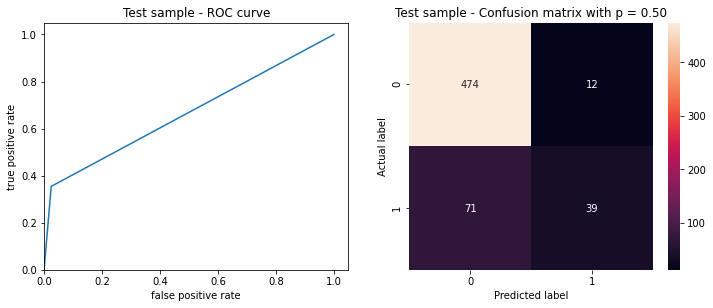

In [26]:
test_labels = data_test['BAD']
plot_metrics("Test sample", test_labels, predictions, p=0.5)

In [27]:
print_metrics(calculate_correlation_matrix(test_labels, predictions), metrics)

Correlation matrix info
True Negatives - No default loans that pay 474
False Positives - No default loans that dont pay 12
False Negatives - Default loans that pay 71
True Positives: - Default loans that dont pay 39
Total Defauts:  110

--------------------

Evalutation Metrics
accuracy : 0.8607383
accuracy_baseline : 0.81543624
auc : 0.800823
auc_precision_recall : 0.58506906
average_loss : 0.37529644
label/mean : 0.18456376
loss : 0.37543163
precision : 0.7647059
prediction/mean : 0.2267966
recall : 0.35454544
global_step : 2146


## Model B: pre-made Estimator - BoostedTreesClassifier

### Build the pre-made Estimator

In [28]:
BATCH_LAYER = 29
def build_estimator(feature_columns, learning_rate=0.1):
    '''
    Given feature columns, 
    build a BoostedTreesClassifier Estimator
    :param feature_columns:
    :param learning_rate:
    :return:
    '''
    feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float32')
    
    runconfig = tf.estimator.RunConfig(tf_random_seed=8)
    
    boosted_trees_classifier = tf.estimator.BoostedTreesClassifier(
    model_dir=LOGS_DIR,
    feature_columns=feature_columns,
    n_classes=2,
    n_batches_per_layer=BATCH_LAYER,
    learning_rate=learning_rate
    )
    
    return boosted_trees_classifier

In [29]:
estimator = build_estimator(feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tf/modelops-sas-tensorflow-workflow-manager-openshift/notebooks/../logs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
The old _FeatureColumn APIs are be

### Train pre-made Estimator

In [30]:
def train_and_evaluate():
    # Get dataset
    train_input_fn = get_dataset(data_train, 'BAD', batch_size=500, mode='train')
    test_input_fn = get_dataset(data_test, 'BAD', batch_size=500)
    # Get Features
    feature_columns = get_features(NUMERICAL_VARIABLES, CATEGORICAL_VARIABLES, labels_dict)
    #Clean all
    shutil.rmtree(LOGS_DIR, ignore_errors = True) 
    # Get estimator
    estimator = build_estimator(feature_columns)
    # Train the estimator
    estimator_train = estimator.train(input_fn=train_input_fn)
    # Evaluate 
    metrics = estimator_train.evaluate(input_fn=test_input_fn)
    return estimator_train, metrics

In [31]:
model, metrics, _, _= mlflow_experiment_tracker('BoostedTreesClassifier')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tf/modelops-sas-tensorflow-workflow-manager-openshift/notebooks/../logs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done callin

### Evaluate pre-made Estimator

In [32]:
predictions_dictionary = list(model.predict(test_input_fn))
predictions = pd.Series([pred['class_ids'] for pred in predictions_dictionary])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tf/modelops-sas-tensorflow-workflow-manager-openshift/notebooks/../logs/model.ckpt-2117
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


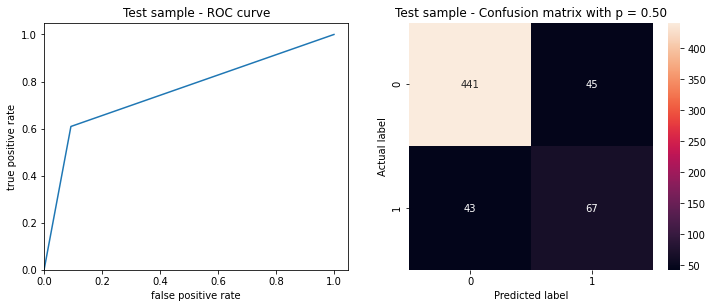

In [33]:
test_labels = data_test['BAD']
plot_metrics("Test sample", test_labels, predictions, p=0.5)

In [34]:
print_metrics(calculate_correlation_matrix(test_labels, predictions), metrics)

Correlation matrix info
True Negatives - No default loans that pay 441
False Positives - No default loans that dont pay 45
False Negatives - Default loans that pay 43
True Positives: - Default loans that dont pay 67
Total Defauts:  110

--------------------

Evalutation Metrics
accuracy : 0.852349
accuracy_baseline : 0.81543624
auc : 0.84884024
auc_precision_recall : 0.51022846
average_loss : 9542718000.0
label/mean : 0.18456376
loss : 9479100000.0
precision : 0.59821427
prediction/mean : 0.23539944
recall : 0.6090909
global_step : 2117


### Which is the best model?

After compare them in Mlflow, we assume that **the best model is boosted_trees_classifier**

**Comment**: Models are really bad. Data are too much unbalanced. Need to change the strategy. 

---

# 5. Model Serving

## Save your model

In [42]:
setup(BASE_DIR_PATH, 'HMEQ/models')

Directory  /tf/modelops-sas-tensorflow-workflow-manager-openshift/notebooks/HMEQ/models  created!


'/tf/modelops-sas-tensorflow-workflow-manager-openshift/notebooks/HMEQ/models'

In [47]:
print(MODELS_DIR)

/tf/modelops-sas-tensorflow-workflow-manager-openshift/notebooks/../models


In [49]:
VERSION = 1
DATE = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
ID = "_".join([str(DATE), str(VERSION)])
EXPORT_PATH = os.path.join(MODELS_DIR, ID, '1')

In [50]:
serving_input_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(tf.feature_column.make_parse_example_spec(feature_columns))

In [51]:
estimator.export_saved_model(EXPORT_PATH, serving_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: ['serving_default', 'classification']
INFO:tensorflow:Signatures INCLUDED in export for Regress: ['regression']
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from /tf/modelops-sas-tensorflow-workflow-manager-openshift/notebooks/../logs/model.ckpt-2117
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:SavedModel written to: /bd-fs-mnt/TenantShare/HMEQ/models/20201119185407_1/temp-1605812051/saved_model.pb


b'/bd-fs-mnt/TenantShare/HMEQ/models/20201119185407_1/1605812051'

In [52]:
%%bash
export DIR=../models/20201019055831_1/1603087114
saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir $DIR

The given SavedModel SignatureDef contains the following input(s):
  inputs['inputs'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: input_example_tensor:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['classes'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 2)
      name: boosted_trees/head/Tile:0
  outputs['scores'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: boosted_trees/head/predictions/probabilities:0
Method name is: tensorflow/serving/classify


2020-11-19 18:54:15.337271: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2020-11-19 18:54:15.337320: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Test it with Docker via Restful API

I could do that using Python Docker client. 

Check my project here: https://github.com/IvanNardini/modelops-aws-web-endpoint-hosted/blob/master/notebooks/02_engineering.ipynb

In that case, go on terminal and run the following commands.

In my case...

```bash
docker pull tensorflow/serving
EXPORT_BASE_DIR=/home/ubuntu/modelops-sas-tensorflow-workflow-manager-openshift/models/20200927165533_1/
docker run -t --rm --name tf -p 8501:8501 -v "$EXPORT_BASE_DIR:/models/model" tensorflow/serving
SERVER=$(hostname -I | cut -d ' ' -f1)
curl -d '{"examples":[{"LOAN": 34400.0, "MORTDUE": 97971.0, "VALUE": 145124.0, "YOJ": 13.0, "DEROG": 0.0, "DELINQ": 0.0, "CLAGE": 67.832, "NINQ": 1.0, "CLNO": 36.0, "DEBTINC": 40.402, "REASON": "DebtCon", "JOB": "Other"}]}' -X POST http://$SERVER:8501/v1/models/model:classify
```

---

# 6. Wrap Up and Project Metadata

## Comments

The Champion model is **boosted_trees_classifier**

But because data are too much unbalanced. Need to change the strategy. 

Futher investigations are required.


## Setup Champion Folder

In [57]:
CHAMPION_PATH = DATA_DIR_PATH + '/models/20201119185407_1/1605812051/1'
DELIVERS_DIR = os.path.join(BASE_DIR_PATH, 'deliverables')
CHAMPION_DELIVER_PATH = DATA_DIR_PATH + '/deliverables/champion'

setup(DELIVERS_DIR, 'champion')
copytree(CHAMPION_PATH, CHAMPION_DELIVER_PATH)

Directory  /bd-fs-mnt/TenantShare/HMEQ/deliverables/champion  created!
